FIRST STEPS

In [1]:
from utils import *

In [2]:

# Load datasets
train_images_b, train_labels_b = load_dataset_split_sobel('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split_sobel('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split_sobel('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split_sobel('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split_sobel('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split_sobel('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





KeyboardInterrupt: 

In [ ]:
# Create TensorFlow datasets (unchanged)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# # Calculate class weights based on TRAINING SET
# class_weights = compute_class_weight('balanced', 
#                                    classes=np.unique(train_labels), 
#                                    y=train_labels)
# class_weight = {0: class_weights[0], 1: class_weights[1]}
class_weight = {0: 1, 1: 5}  # probamos otros pesos

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
def create_model(optimizer='adam', dropout_rate=0.2, l2_reg=0.01):
    model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'l2_reg': [0.01, 0.1, 0.2]
}

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr])

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 3s 67ms/step - loss: 0.2760 - accuracy: 0.8998 - precision_2: 0.9296 - recall_2: 0.8810 - auc_2: 0.9619
Test Accuracy: 0.8998287916183472
Test Precision: 0.929648220539093
Test Recall: 0.8809523582458496
Test AUC: 0.961947500705719


37/37 [==============================] - 3s 67ms/step


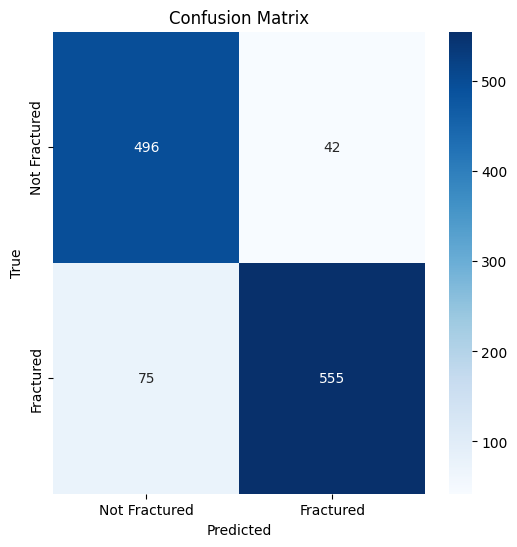

In [ ]:
plot_conf_matrix(model, test_images, test_labels)

In [ ]:
filename = 'binary_model_v4_3_augmented_sobel.pkl'
create_pkl(filename, model)

In [ ]:
model.save('binary_model_v4_3_augmented.h5') 

c:\Users\Nacho MPra\.conda\envs\fracture_detection\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 3s 87ms/step


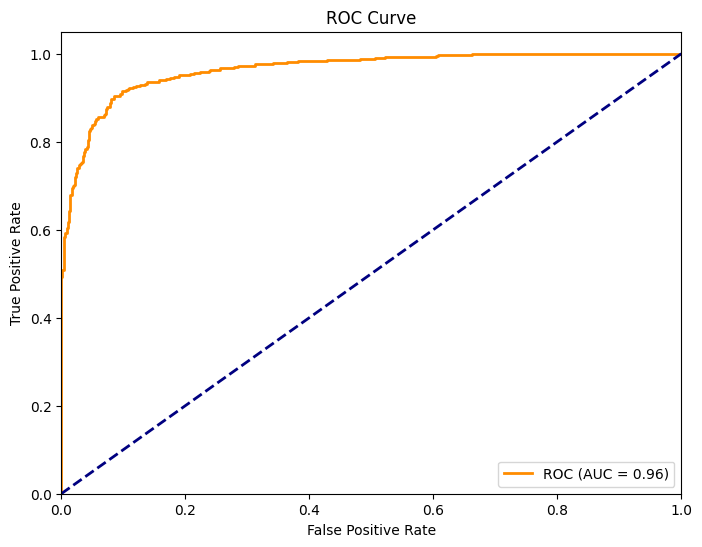

In [ ]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 2s 59ms/step


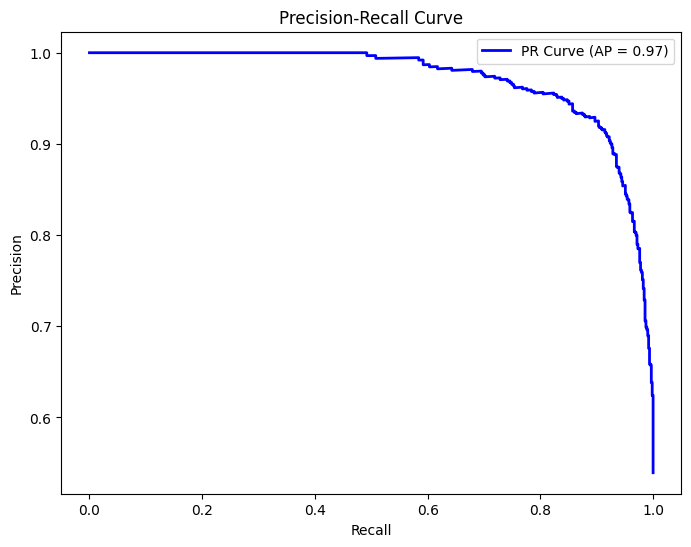

In [ ]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 2s 54ms/step


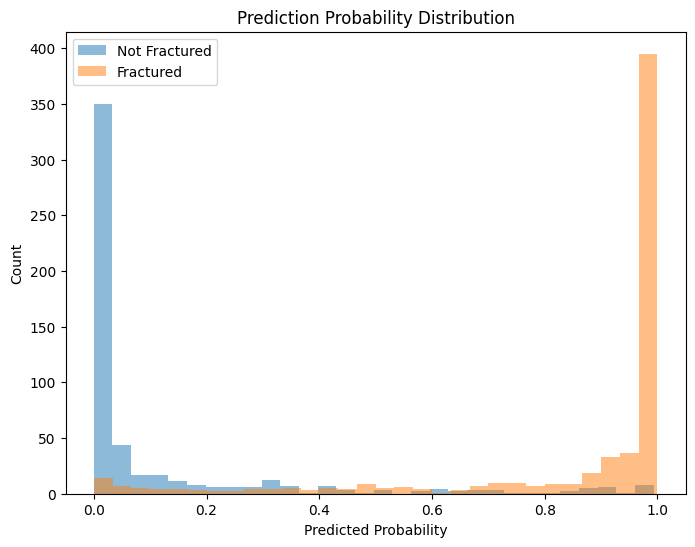

In [ ]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 2s 60ms/step


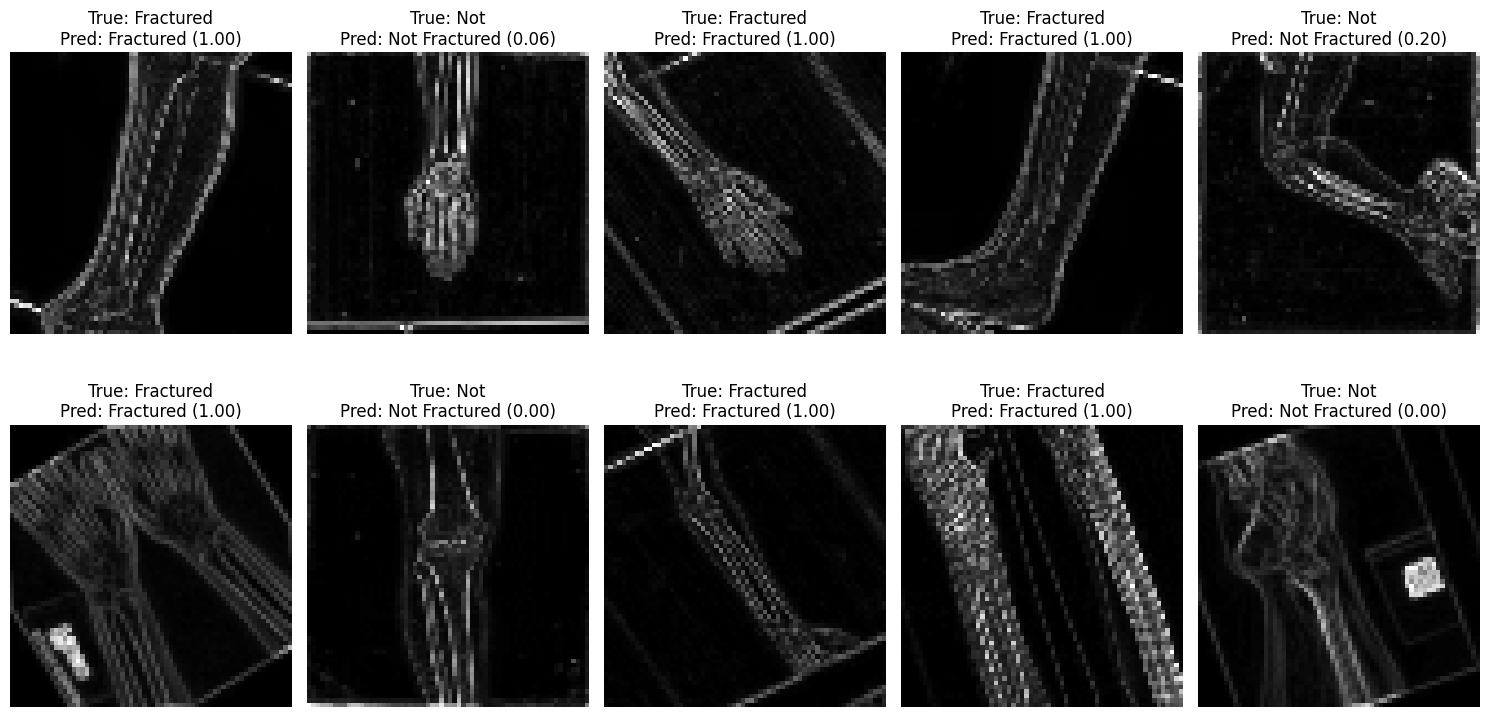

In [ ]:
show_ten_samples(model, test_images, test_labels)

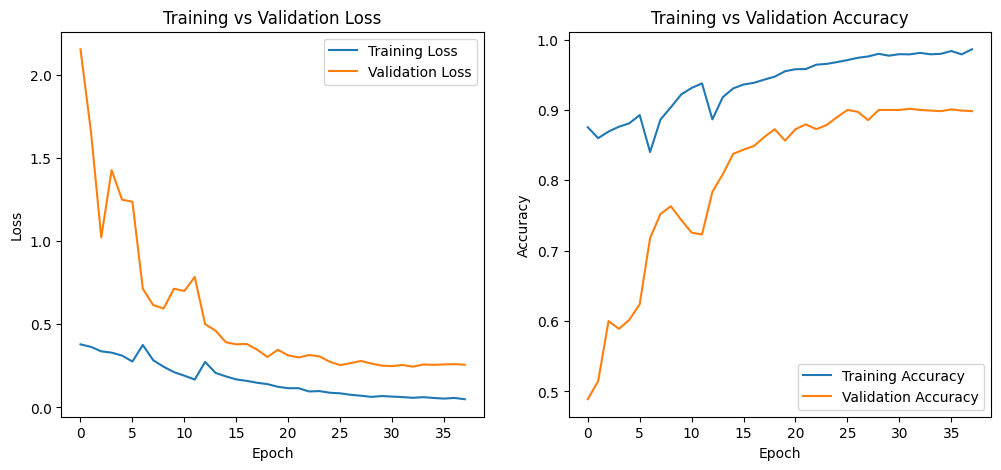

In [ ]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.